# Data Processing and Feature Engineering for Enhanced Forecasting Models at Delhivery

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
df = pd.read_csv("https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/551/original/delhivery_data.csv?1642751181")
df.head(5)

In [ ]:
# Dimension of the dataset
df.ndim

In [ ]:
# Shape of dataset
print("Shape: ",df.shape)

In [ ]:
# Concise summary of dataframe
df.info()

In [ ]:
# Number of duplicate values
df.duplicated().sum()

In [ ]:
# Number of null values in each feature
print("Total number of null values: ",df.isna().sum().sum())
print(df.isna().sum())

#### Removing null values

In [ ]:
df = df.dropna(how='any')
df = df.reset_index(drop=True)

#### Converting time columns into pandas dataframe

In [ ]:
df['od_start_time'] = pd.to_datetime(df['od_start_time'])
df['od_end_time'] = pd.to_datetime(df['od_end_time'])

In [ ]:
# Converting object into category type
df['data'] = df['data'].astype('category')
df['route_type'] = df['route_type'].astype('category')

In [ ]:
df.info()

In [ ]:
df['segment'] = df['trip_uuid'] + df['source_center'] + df['destination_center']

segment_cols = ['segment_actual_time', 'segment_osrm_time', 'segment_osrm_distance']

for col in segment_cols:
    df[col+ '_sum'] = df.groupby('segment')[col].cumsum()

df[[col+ '_sum' for col in segment_cols]]

#### Aggregating at sub-journey level

In [ ]:
create_segment_dict = {
    'data' : 'first',
    'trip_creation_time': 'first',
    'route_schedule_uuid' : 'first',
    'route_type' : 'first',
    'trip_uuid' : 'first',
    'source_center' : 'first',
    'source_name' : 'first',

    'destination_center' : 'last',
    'destination_name' : 'last',

    'od_start_time' : 'first',
    'od_end_time' : 'first',
    'start_scan_to_end_scan' : 'first',

    'actual_distance_to_destination' : 'last',
    'actual_time' : 'last',

    'osrm_time' : 'last',
    'osrm_distance' : 'last',

    'segment_actual_time_sum' : 'last',
    'segment_osrm_distance_sum' : 'last',
    'segment_osrm_time_sum' : 'last',

    }
    

#### Groupby mini-trips, sorting by time

In [ ]:
segment = df.groupby('segment').agg(create_segment_dict).reset_index()
segment = segment.sort_values(by=['segment','od_end_time'],ascending=True).reset_index(drop=True)

In [ ]:
segment

In [ ]:
# Concise summary
segment.info()

### Calculate time taken between od_start_time and od_end_time and keep it as a feature

In [ ]:
segment['ord_diff_hour'] = (segment['od_end_time'] - segment['od_start_time']).dt.total_seconds()/60
segment['ord_diff_hour']

##### *ord_diff_hour is almost equal to start_scan_to_end_scan feature/column*

In [ ]:
create_trip_dict = {

    'data' : 'first',
    'trip_creation_time': 'first',
    'route_schedule_uuid' : 'first',
    'route_type' : 'first',
    'trip_uuid' : 'first',

    'source_center' : 'first',
    'source_name' : 'first',

    'destination_center' : 'last',
    'destination_name' : 'last',

    'start_scan_to_end_scan' : 'sum',
    'ord_diff_hour' : 'sum',

    'actual_distance_to_destination' : 'sum',
    'actual_time' : 'sum',
    'osrm_time' : 'sum',
    'osrm_distance' : 'sum',

    'segment_actual_time_sum' : 'sum',
    'segment_osrm_distance_sum' : 'sum',
    'segment_osrm_time_sum' : 'sum',

    }

In [ ]:
# Peforming groupby on trip_uuid to find total time and distance of trip
trips = segment.groupby('trip_uuid').agg(create_trip_dict).reset_index(drop=True)

In [ ]:
trips.head()

## Hypothesis testing

In [ ]:
# lowering columns with string function
trips['destination_name'] = trips['destination_name'].str.lower()
trips['source_name'] = trips['source_name'].str.lower()

In [ ]:
# Functions for creating features from destination name
def place_to_state(x):
    state = x.split('(')[1][:-1]
    return state

def place_to_city(x):
    city = x.split('(')[0].split('_')[0]
    return city

def place_to_city_place(x):
    x = x.split(' (')[0]

    length = len(x.split('_'))

    if length >= 3:
        return x.split('_')[1]

    if length == 2:
        return x.split('_')[0]

    return x.split(' ')[0]


def place_to_code(x):
    x = x.split(' (')[0]

    if len(x.split('_')) >=3:
        return x.split('_')[-1]
    return None

In [ ]:
trips['destination_state'] = trips['destination_name'].apply(lambda x: place_to_state(x))
trips['destination_city']  = trips['destination_name'].apply(lambda x: place_to_city(x))
trips['destination_place'] = trips['destination_name'].apply(lambda x: place_to_city_place(x))
trips['destination_code']  = trips['destination_name'].apply(lambda x: place_to_code(x))

In [ ]:
# Last 5 columns
trips.select_dtypes('object').iloc[:,-5:]

### Changing required column into datetime

In [ ]:
trips['trip_creation_time'] = pd.to_datetime(trips['trip_creation_time'])

trips['year'] = trips['trip_creation_time'].dt.year
trips['month'] = trips['trip_creation_time'].dt.month
trips['hour'] = trips['trip_creation_time'].dt.hour
trips['day'] = trips['trip_creation_time'].dt.day
trips['week'] = trips['trip_creation_time'].dt.isocalendar().week
trips['dayofweek'] = trips['trip_creation_time'].dt.dayofweek

In [138]:
# New created features
trips.iloc[:,-6:]

,year,month,hour,day,week,dayofweek
0,2018,9,0,12,37,2
1,2018,9,0,12,37,2
2,2018,9,0,12,37,2
3,2018,9,0,12,37,2
4,2018,9,0,12,37,2
...,...,...,...,...,...,...
14782,2018,10,23,3,40,2
14783,2018,10,23,3,40,2
14784,2018,10,23,3,40,2
14785,2018,10,23,3,40,2


In [139]:
# choose numerical/float features
trip = trips.select_dtypes(include='float')
trip

,start_scan_to_end_scan,ord_diff_hour,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,segment_actual_time_sum,segment_osrm_distance_sum,segment_osrm_time_sum
0,2259.0,2260.109800,824.732854,1562.0,717.0,991.3523,1548.0,1320.4733,1008.0
1,180.0,181.611874,73.186911,143.0,68.0,85.1110,141.0,84.1894,65.0
2,3933.0,3934.362520,1927.404273,3347.0,1740.0,2354.0665,3308.0,2545.2678,1941.0
3,100.0,100.494935,17.175274,59.0,15.0,19.6800,59.0,19.8766,16.0
4,717.0,718.349042,127.448500,341.0,117.0,146.7918,340.0,146.7919,115.0
...,...,...,...,...,...,...,...,...,...
14782,257.0,258.028928,57.762332,83.0,62.0,73.4630,82.0,64.8551,62.0
14783,60.0,60.590521,15.513784,21.0,12.0,16.0882,21.0,16.0883,11.0
14784,421.0,422.119867,38.684839,282.0,48.0,58.9037,281.0,104.8866,88.0
14785,347.0,348.512862,134.723836,264.0,179.0,171.1103,258.0,223.5324,221.0


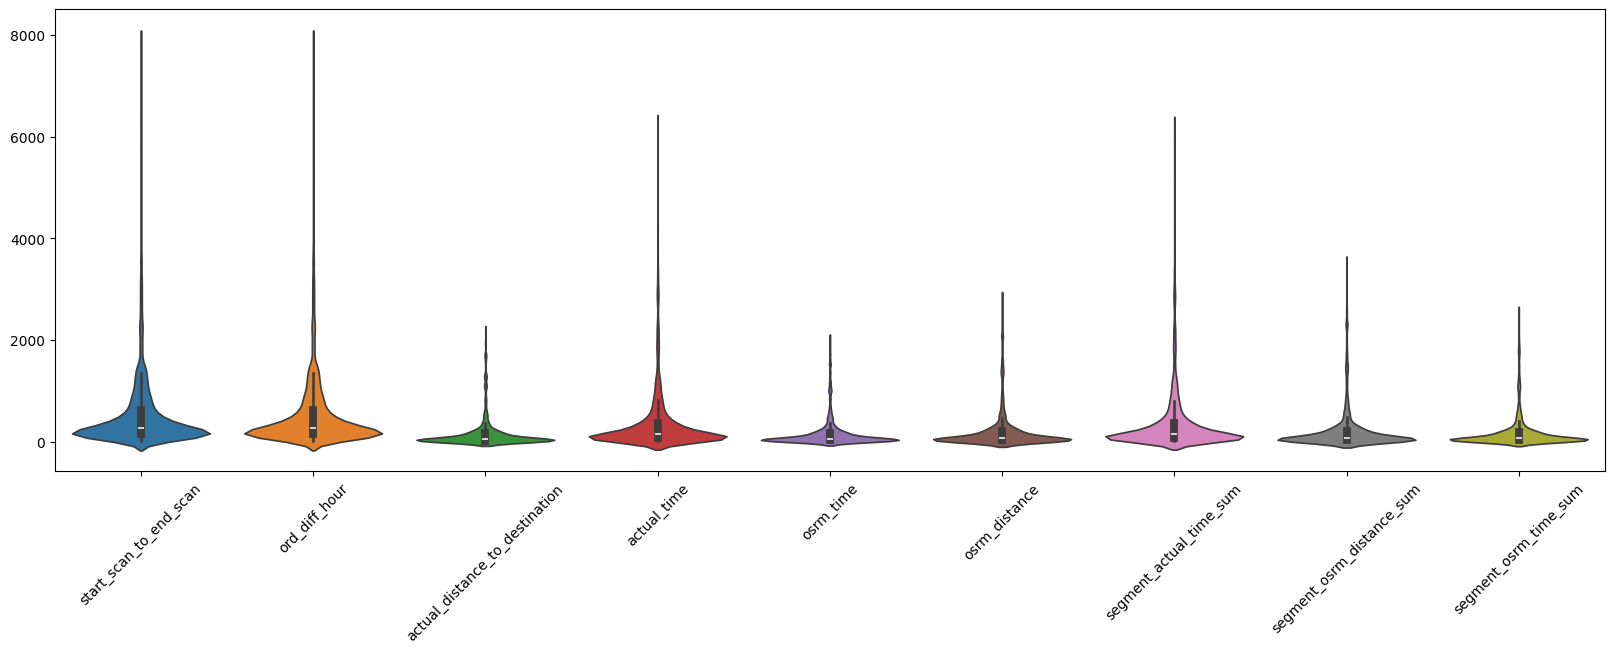

In [137]:
# Checking outliers using violinplot
plt.figure(figsize=(20,6))
sns.violinplot(data = trip)
plt.xticks(rotation=45)
plt.draw()

##### *The long tail in every column clearly shows that there are outliers in all the numerical columns*